In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [5]:
file = 'params_texel'

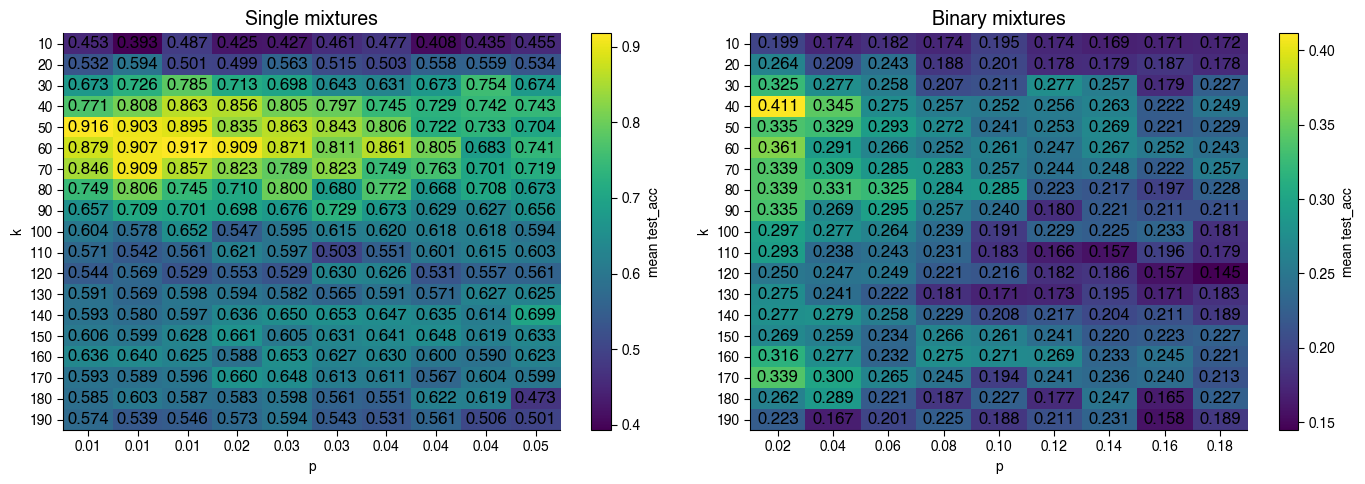

In [6]:
def load_grid(path):
    """Load a gridsearch pickle and return (grid, ku, pu)."""
    with open(path, "rb") as f:
        d = pickle.load(f)
    k  = np.asarray(d["params"]["k"])
    p  = np.asarray(d["params"]["p"])
    ta = np.asarray(d["results"]["test_acc"], dtype=float)

    idx = np.lexsort((p, k))
    ks, ps, tas = k[idx], p[idx], ta[idx]

    chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
    starts = np.r_[0, np.flatnonzero(chg) + 1]

    sums   = np.add.reduceat(tas, starts)
    counts = np.diff(np.r_[starts, tas.size])
    means  = sums / counts

    ku = np.unique(k)
    pu = np.unique(p)
    grid = np.full((ku.size, pu.size), np.nan)
    grid[np.searchsorted(ku, ks[starts]),
         np.searchsorted(pu, ps[starts])] = means
    return grid, ku, pu

# --- load both datasets ---
grid1, ku1, pu1 = load_grid(f"data/{file}.pkl")
grid2, ku2, pu2 = load_grid("data/params_texel_binary.pkl")

# --- plot side by side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for ax, grid, ku, pu, title in [
    (ax1, grid1, ku1, pu1, "Single mixtures"),
    (ax2, grid2, ku2, pu2, "Binary mixtures"),
]:
    im = ax.imshow(grid, aspect="auto")
    ax.set_xticks(np.arange(pu.size))
    ax.set_xticklabels([f"{v:.2f}" for v in pu])
    ax.set_yticks(np.arange(ku.size))
    ax.set_yticklabels(ku)
    ax.set_xlabel("p")
    ax.set_ylabel("k")
    ax.set_title(title)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if np.isfinite(grid[i, j]):
                ax.text(j, i, f"{grid[i, j]:.3f}", ha="center", va="center")

    fig.colorbar(im, ax=ax, label="mean test_acc")

plt.tight_layout()
plt.show()

In [ ]:
# --- Plot test accuracies from gridsearch_stochastic.py (s × k × p grid) ---
with open(f"data/{file}.pkl", "rb") as f:
    d = pickle.load(f)

s_arr = np.asarray(d["params"]["s"])
k_arr = np.asarray(d["params"]["k"])
p_arr = np.asarray(d["params"]["p"])
test_acc = np.asarray(d["results"]["test_acc"], dtype=float)

su = np.unique(s_arr)
ku = np.unique(k_arr)
pu = np.unique(p_arr)

# Average over folds for each (s, k, p) combination
grid_3d = np.full((su.size, ku.size, pu.size), np.nan)
for si, sv in enumerate(su):
    for ki, kv in enumerate(ku):
        for pi, pv in enumerate(pu):
            mask = (s_arr == sv) & (k_arr == kv) & (p_arr == pv)
            if mask.any():
                grid_3d[si, ki, pi] = test_acc[mask].mean()

ncols = min(len(su), 3)
nrows = int(np.ceil(len(su) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)

for idx, sv in enumerate(su):
    ax = axes[idx // ncols, idx % ncols]
    im = ax.imshow(grid_3d[idx], aspect="auto", vmin=np.nanmin(grid_3d), vmax=np.nanmax(grid_3d))
    ax.set_xticks(np.arange(pu.size))
    ax.set_xticklabels([f"{v:.3f}" for v in pu], rotation=45, ha="right")
    ax.set_yticks(np.arange(ku.size))
    ax.set_yticklabels(ku.astype(int))
    ax.set_xlabel("p")
    ax.set_ylabel("k")
    ax.set_title(f"s = {sv:.3f}")
    for i in range(ku.size):
        for j in range(pu.size):
            if np.isfinite(grid_3d[idx, i, j]):
                ax.text(j, i, f"{grid_3d[idx, i, j]:.2f}", ha="center", va="center", fontsize=7)

# Hide unused subplots
for idx in range(len(su), nrows * ncols):
    axes[idx // ncols, idx % ncols].set_visible(False)

fig.colorbar(im, ax=axes.ravel().tolist(), label="Mean test accuracy", shrink=0.8)
fig.suptitle("Stochastic gridsearch: test accuracy (k × p) per s", fontsize=14)
plt.tight_layout()
plt.show()